In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
from scipy.signal import convolve2d
from skimage.measure import block_reduce, find_contours
from matplotlib.patches import Rectangle
from kural_core.models import *
from kural_core.data_processing import *
from kural_core.functions import *
import pickle
from scipy.misc import imresize
from scipy.ndimage import morphology
from scipy.spatial import ConvexHull
from skimage import measure
from matplotlib import animation, rc
from IPython.display import HTML
from os import listdir

PATH = r'D:\Code\kural_work\movie_generation\data\\'


In [2]:
crop_img_tensor = torch.load(PATH+'crop_img_tensor.variable')

In [5]:
ds = torch.utils.data.TensorDataset(crop_img_tensor)
train_idx, val_idx = RandomIndicesForKFoldValidation(len(ds), 0, K=5, rand_seed=42, nORp=1)
bs = 10
train_dl = torch.utils.data.DataLoader(ds,batch_size=bs, sampler=SubsetSampler(train_idx, shuffle=True))
val_dl = torch.utils.data.DataLoader(ds,batch_size=2*bs, sampler=SubsetSampler(val_idx))
model = ConvolutionalAutoencoderModel().cuda()
lr_start = 1e-3
opt = optim.Adam(model.parameters(),lr=lr_start)
train_loss = []
val_loss = []
criterion = nn.MSELoss()

In [38]:
# @do_profile(follow=[])
# def profile_fit():
restarts = 1
# lr_start = 1e-3
lr_end = 1e-5
for restart in range(restarts):
    cycles = 3
    epochs = 20
    print(f'restart number {restart+1} out of {restarts}')
#     if len(train_loss)>0: opt = optim.SGD(model.parameters(),lr=lr_start,momentum=0.9)
    # lr_div = (lr_start/lr_end)**(1/epochs)
    time_list = []
    epoch_time_list = None
    cycle_print_str = 'Cycle: 0 ~ Remaining total: Unknown'
    print(cycle_print_str,end='')
    for cycle in range(cycles):
        ts = time.clock()
        if cycle>0: epochs = epochs*2
        lr_start = lr_start*(0.999)**cycle
        epoch_print_str = f' ~ Epoch: 0 ~ Remaining in cycle: {(epochs*np.mean(epoch_time_list) if epoch_time_list is not None else 0):.3g}s'
        print(epoch_print_str, end='')
        epoch_time_list = []
        for epoch in range(epochs):
            ets = time.clock()
            opt.param_groups[0]['lr'] = lr_end + 0.5*(lr_start-lr_end)*(1+math.cos(cycle/cycles*np.pi))
    #         lr /= lr_div
            running_loss = 0.0
            model.train()
            for data, in train_dl:
                x_train = data.cuda()
                opt.zero_grad()
                y_pred = model(x_train)
                loss = criterion(y_pred.view(-1,128*128),x_train.view(-1,128*128))
                loss.backward()
                opt.step()
                running_loss += loss.item()
            train_loss.append(running_loss/len(train_dl))

            running_loss = 0.0
            model.eval()
            with torch.no_grad():
                for data, in val_dl:
                    x_train = data.cuda()
                    y_pred = model(x_train)
                    running_loss += criterion(y_pred.view(-1,128*128),x_train.view(-1,128*128)).item()
                val_loss.append(running_loss/len(val_dl))
            epoch_time_list.append(time.clock()-ets)
            if epoch_print_str: 
                for _ in range(len(epoch_print_str)):
                    print('\b',end='')
            epoch_print_str = f' ~ Epoch: {epoch+1:2d}/{epochs} ~ Remaining in cycle: {(epochs-(epoch+1))*np.mean(epoch_time_list):.3g}s'
            print(epoch_print_str,end='')
        time_list.append(time.clock()-ts)
        if cycle_print_str: 
            for _ in range(len(cycle_print_str)+len(epoch_print_str)):
                print('\b',end='')
        remaining_time = (cycles-(cycle+1))*np.mean(time_list)
        cycle_print_str = f'Cycle: {cycle+1:3d}/{cycles} ~ Remaining total: {int(remaining_time//60)}m {remaining_time%60:02.0f}s'
        print(cycle_print_str,end='')
    for _ in range(len(cycle_print_str)):
                print('\b',end='')
    print(f'Spent {int(sum(time_list)//60)}m {sum(time_list)%60:2.0f}s doing {cycles*epochs} total steps for an average of {sum(time_list)/cycles/epochs:3.1f}s per step.')
        
#         return (train_loss, val_loss)

# torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\kMeans_autoencoder_model.pth')

restart number 1 out of 1
Spent 215m 26s doing 240 total steps for an average of 53.9s per step.


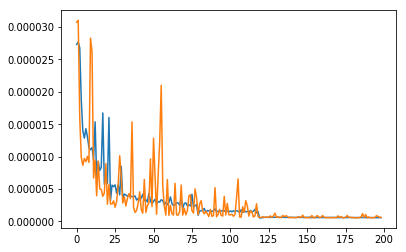

In [39]:
slc = slice(1,len(train_loss))
plt.plot(train_loss[slc])
plt.plot(val_loss[slc])
plt.show()

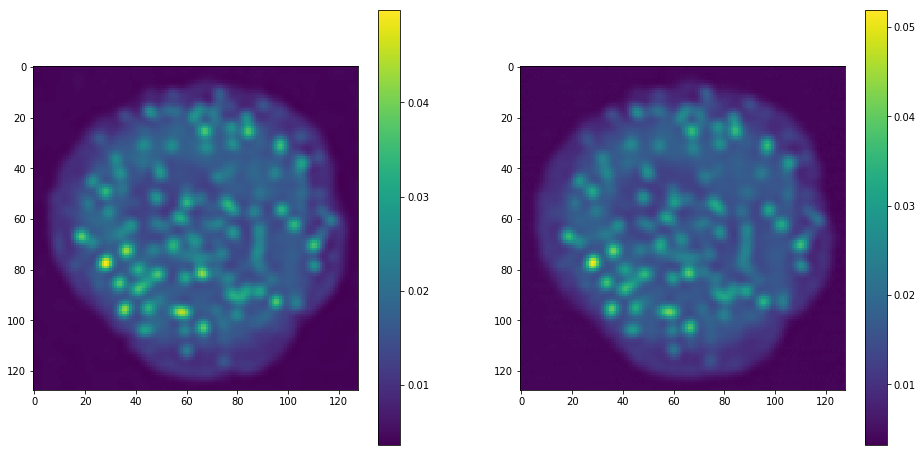

In [51]:
fig, ax = plt.subplots(1,2,figsize=[16,16])
idx = np.random.choice(len(ds))
tmp_img, = ds[idx]
mappable = ax[0].imshow(tmp_img[0])
plt.colorbar(mappable=mappable, ax = ax[0],shrink=0.5)
model.eval()
out_img = model(tmp_img[None].cuda())
mappable = ax[1].imshow(out_img[0,0].data.cpu())
plt.colorbar(mappable=mappable, ax = ax[1],shrink=0.5)
plt.show()

In [52]:
torch.save(model.state_dict(),'C:\\Users\\joshu\\Documents\\fastai\\courses\\kural_work\\convolutional_autoencoder_model.pth')

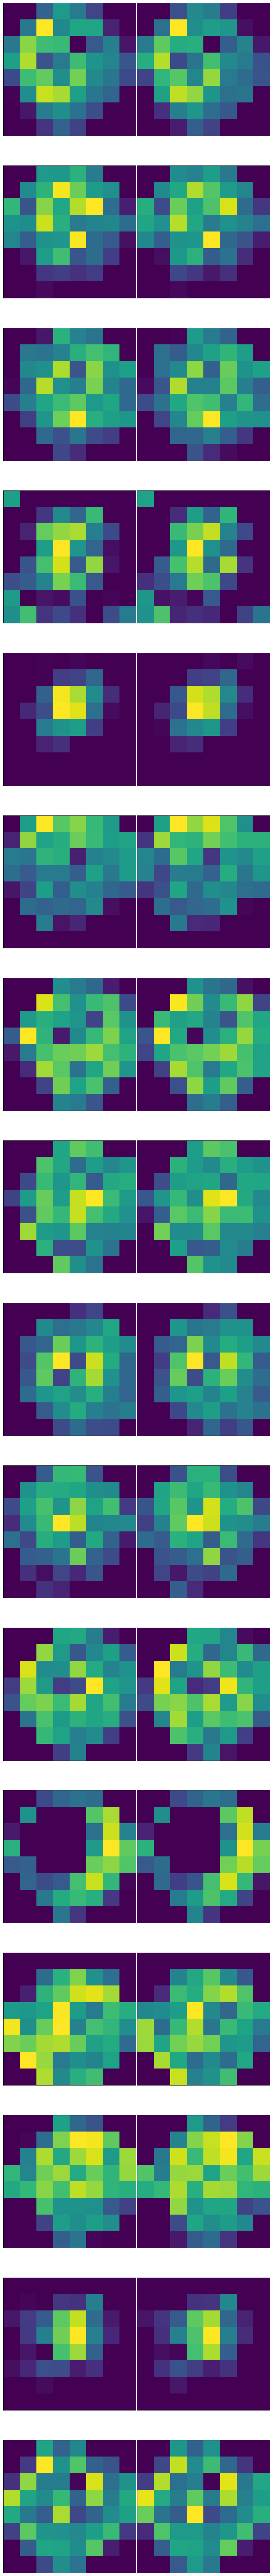

In [69]:
fig, ax = plt.subplots(16,2,figsize=[16,160])
# ax = ax.flatten()
idx = np.random.choice(len(ds))
tmp_img1, = ds[idx]
convs1 = model.convolution(tmp_img1[None].cuda()).data.cpu()
tmp_img2, = ds[idx+1]
convs2 = model.convolution(tmp_img2[None].cuda()).data.cpu()
for i in range(16):
    ax[i,0].imshow(convs1[0,i])
    ax[i,0].set_yticks([])
    ax[i,0].set_xticks([])
    ax[i,1].imshow(convs2[0,i])
    ax[i,1].set_yticks([])
    ax[i,1].set_xticks([])
plt.subplots_adjust(hspace=0.01, wspace=0.01)

In [24]:
p = list(model.parameters())
for i in range(len(p)):
    print((torch.sum(torch.abs(p[i])<1e-8).item()/p[i].numel()))
print('')
for i in range(len(p)):
    print((torch.sum(torch.abs(p[i].grad)==0).item()/p[i].numel()))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0625
0.0
0.125
0.0
0.0625
0.0
0.125
0.0487060546875
0.140625
0.01953125
0.0
0.0
0.1875
0.00341796875
0.1484375
0.0
0.078125
0.0
0.21875
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.03125
0.0
0.03125
0.0
0.0625
0.0
0.125
0.0
0.0
